In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector, Bidirectional, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')

        # read all text
        text = file.read()
        file.close()
        return text

In [ ]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [ ]:
data = read_text("/content/drive/MyDrive/ara_eng.txt")
ara_eng = to_lines(data)
ara_eng = array(ara_eng)

In [ ]:
# Remove punctuation
ara_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ara_eng[:,0]]
ara_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ara_eng[:,1]]

ara_eng

array([['Hi', 'مرحبًا'],
       ['Run', 'اركض'],
       ['Help', 'النجدة'],
       ...,
       ['during last year s challenge we also met language champions who participated by creating memes in berrichon bourbonnais karuk fulfulde wiradjuri quechua and kwakwala memes in hundreds of languages were created and shared online you can see a selection of these memes in this summary post from last year s campaign',
        'تعرفنا خلال تحدي العام الماضي على ابطال لغويين شاركوا في حملتنا بابداع ميمز بلغات الكيتشوا الكواكوالا الكاروك الويرادجوري والبيروشونية الى جانب الميات من اللغات الاخرى بامكانك الاطلاع على مجموعة من الميمز المشاركة في تحدي العام السابق هنا نظرة على تحدي ابداع ميم بلعتك الام'],
       ['to take part just follow the simple steps outlined on the challenge s website http mememl org which includes finding an image adding text and hashtags including mememl and sharing on your favorite social media platform make sure you tag someone inviting them to create their own meme in their

In [ ]:
# convert text to lowercase
for i in range(len(ara_eng)):
   ara_eng[i,0] = ara_eng[i,0].lower()
   ara_eng[i,1] = ara_eng[i,1].lower()

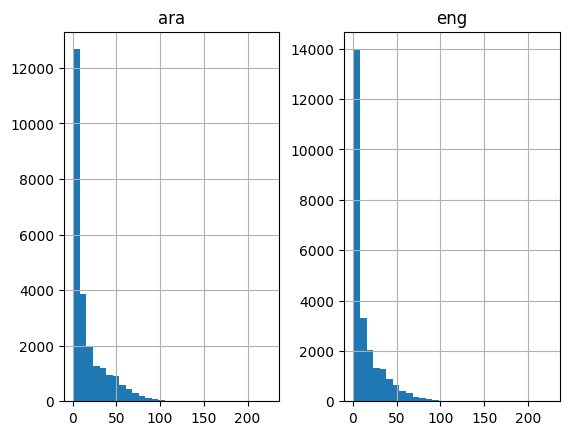

In [ ]:
# empty lists
eng_l = []
ara_l = []

# populate the lists with sentence lengths
for i in ara_eng[:,0]:
      ara_l.append(len(i.split()))

for i in ara_eng[:,1]:
      eng_l.append(len(i.split()))

length_df = pd.DataFrame({'ara':ara_l,'eng':eng_l })

length_df.hist(bins = 30)
plt.show()

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
ara_tokenizer = tokenization(ara_eng[:, 0])
ara_vocab_size = len(ara_tokenizer.word_index) + 1

ara_length = max([len(sentence.split()) for sentence in ara_eng[:, 0]])

print('Arabic Vocabulary Size and ara_length: %d' % ara_vocab_size,ara_length)

Arabic Vocabulary Size and ara_length: 26055 225


In [ ]:
# prepare Deutch tokenizer
eng_tokenizer = tokenization(ara_eng[:, 1])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = max([len(sentence.split()) for sentence in ara_eng[:, 1]])

print('English Vocabulary Size and english_length: %d' % eng_vocab_size,eng_length)

English Vocabulary Size and english_length: 57852 225


In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [ ]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(ara_eng, test_size=0.2, random_state = 12)

In [ ]:
# prepare training data
trainX = encode_sequences(ara_tokenizer, ara_length, train[:, 0])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 1])

# prepare validation data
testX = encode_sequences(ara_tokenizer, ara_length, test[:, 0])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 1])

In [ ]:
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()

    # Input embedding layer for the source language
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))

    # Bidirectional Encoder LSTM
    model.add(Bidirectional(LSTM(units)))  # Processes input in both directions

    # Repeat the context vector to feed into the decoder
    model.add(RepeatVector(out_timesteps))

    # Bidirectional Decoder LSTM
    model.add(Bidirectional(LSTM(units, return_sequences=True)))  # Outputs full sequence

    # Output layer
    model.add(Dense(out_vocab, activation='softmax'))

    return model

In [ ]:
model = define_model(ara_vocab_size, eng_vocab_size, ara_length, eng_length, 128)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
rms = optimizers.RMSprop(learning_rate=0.001)

model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
best_model_filepath = 'model.h1.6_oct_2024.keras'
checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=50, batch_size=32, validation_split = 0.2,callbacks=[checkpoint],
                    verbose=1)
